In [1]:
%matplotlib inline 
# magic function, control all plots are within same webpage for ipython notebook

import numpy
import matplotlib.pyplot as plt
from scipy.misc import imread

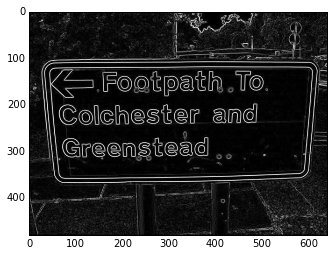

In [2]:
from skimage.filters import sobel

img = imread('../data/ex2/raw/100.jpg')
#gtimg = imread('../data/ex2/')
plt.imshow(sobel(img), cmap = 'gray')
plt.show()

cbname = '../codebooks/cb1000/codeBook.npy'
cb = numpy.load(cbname)
cb = numpy.reshape(cb, (1000, 8, 8))

img = numpy.float32(img)
cb = numpy.float32(cb)

image size (480, 640)
average time 0.0688444139957


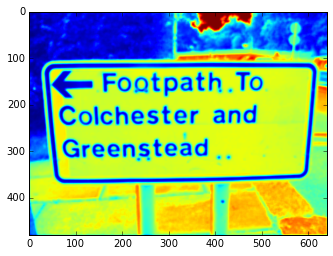

In [29]:
from scipy.signal import convolve2d
import time

t0 = time.time()
for i, c in enumerate(cb):
    #print i
    convout = convolve2d(img, c, mode = 'same')
    t = time.time() - t0
print 'image size', img.shape
print 'average time', t/1000
plt.imshow(convout)
plt.show()

[ConvOp{('imshp', (1, 480, 640)),('kshp', (8, 8)),('nkern', 1000),('bsize', 1),('dx', 1),('dy', 1),('out_mode', 'full'),('unroll_batch', 1),('unroll_kern', 10),('unroll_patch', False),('imshp_logical', (1, 480, 640)),('kshp_logical', (8, 8)),('kshp_logical_top_aligned', True)}(<TensorType(float64, 4D)>, <TensorType(float64, 4D)>)]
average time 0.231134040356
Used the gpu


Using gpu device 0: GeForce GTX 480


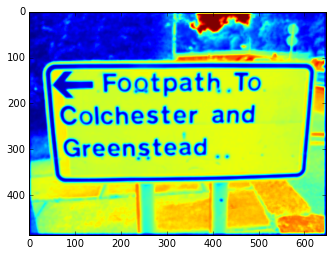

In [3]:
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time
from theano.tensor.nnet import conv
import theano.sandbox.cuda

newimg = numpy.empty((1, 1, 480, 640), dtype = numpy.float32)
newimg[0, 0, :, :] = img
newcb = numpy.empty((1000, 1, 8, 8), dtype = numpy.float32)
newcb[:, 0, :, :] = cb

symimg = T.dtensor4()
symfilter = T.dtensor4()
image_shape = (1, 1, 480, 640)
filter_shape = (1000, 1, 8, 8)
sym_convout = conv.conv2d(
            input=symimg,
            filters=symfilter,
            filter_shape=filter_shape,
            image_shape=image_shape, 
            border_mode = 'full'
        )
f = function([symimg, symfilter], sym_convout)
print f.maker.fgraph.toposort()


t0 = time.time()
convout = f(newimg, newcb)
print 'average time', (time.time() - t0)/100

if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print 'Used the cpu'
else:
    print 'Used the gpu'
plt.imshow(convout[0, -1, :, :])
plt.show()

In [4]:
from theano import function, config, shared, sandbox
from pylearn2.sandbox.cuda_convnet.filter_acts import FilterActs
from theano.sandbox.cuda.basic_ops import gpu_contiguous
import theano.tensor as T

conv_op = FilterActs()
inputs = T.ftensor4()
filters = T.ftensor4()

input_shuffled = inputs.dimshuffle(1, 2, 3, 0) # bc01 to c01b
filters_shuffled = filters.dimshuffle(1, 2, 3, 0) # bc01 to c01b
filters_flipped = filters_shuffled[:, ::-1, ::-1, :] # flip rows and columns
contiguous_input = gpu_contiguous(input_shuffled)
contiguous_filters = gpu_contiguous(filters_flipped)
out_shuffled = conv_op(contiguous_input, contiguous_filters)
#out_shuffled = conv_op(input_shuffled, filters_flipped)
out = out_shuffled.dimshuffle(3, 0, 1, 2) # c01b to bc01

f = function([inputs, filters], out)

In [9]:
newimg = numpy.empty((1, 1, 480, 640))
newimg[0, 0, :, :] = img
newcb = numpy.empty((1000, 1, 8, 8))
newcb[:, 0, :, :] = cb

newimg = numpy.float32(newimg)[:, :, :, :480]
newcb = numpy.float32(newcb)[:16]
print newimg.shape
print newcb.shape

(1, 1, 480, 480)
(16, 1, 8, 8)


In [ ]:
print f.maker.fgraph.toposort()


t0 = time.time()
convout = f(newimg, newcb)
print 'average time', (time.time() - t0)/100

if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print 'Used the cpu'
else:
    print 'Used the gpu'
plt.imshow(convout[0, -1, :, :])
plt.show()

mode

In [61]:
mode = mode.including('conv_fft')